<center>

# Proyecto final: **Crecimiento Poblacional en México (2022-2100)**

## **Manuel Jesús Casillas Olivier**

### **Temas Selectos de Física Computacional I: Inteligencia Artificial en la Física**

**14 / 12 / 2022**

</center>

---







**Breve introducción:**

> El 15 de noviembre del 2022 la población mundial alcanzó el número de 8 mil millones de personas. Nuevamente surge el debate de si la cantidad de personas habitando la tierra es "considerablemente" relevante para el aceleramiento del cambio climático, aumento en la contaminación del aire, tierra y agua, la extinción de especies producto del desplazamiento de sus hábitats por el incremento de las actividades humanas, la lucha por el espacio, etc. Sin duda la sobrepoblación es un problema, pero tendría que discutirse si tiene más que ver más con factores políticos y económicos que con un problema númerico en sí.

Según las cifras de [Expansión](https://datosmacro.expansion.com/paises/mexico#:~:text=M%C3%A9xico,%20con%20una%20poblaci%C3%B3n%20de,66%20habitantes%20por%20Km2.), en 2022 la población de México alcanzó la cifra de 130,262,220 personas.






<center>

## **1. Problema a resolver:**

</center>


Se realizará un modelo que predecirá la evolución del incremento poblacional de México hasta 2100. Se puede caracterizar al crecimiento de la población con diferentes inputs o rasgos, como la tasa de mortalidad, tasa de natalidad, etc. Sin embargo, en este caso basta con el año transcurrido ( $t$ ) como variable independiente y la población al término de dicho año ( $P$ ) para establecer la relación:

<center>

$P = P(t)$

</center>

De esta manera, el único output de interés para la solución del problema es $P(t)$ y el objetivo fundamental de este proyecto es caracterizar cuantitativamente su evolución en el intervalo de tiempo $[ t_0 = 2022, t_f = 2100]$.

Los datos son obtenidos de los siguientes sitios web:

[1] [Banco Mundial](https://datos.bancomundial.org/indicador/sp.pop.grow?locations=MX)

[2] [Gobierno de México](https://datos.gob.mx/busca/dataset/proyecciones-de-la-poblacion-de-mexico-y-de-las-entidades-federativas-2016-2050/resource/b29b9649-72bc-48e7-9edd-c385b0f450e8)

[3] [INEGI](https://cuentame.inegi.org.mx/poblacion/habitantes.aspx)

[4] [Expansión](https://datosmacro.expansion.com/demografia/poblacion/mexico)

[5] [Revista Iberoamericana 3ra ed. Vol. 12 (2003) Págs. 25-52](https://journals.iai.spk-berlin.de/index.php/iberoamericana/article/download/628/312)

A partir de las anteriores fuentes se contruyó un archivo .csv para un mejor manejo con la paquetería pandas de python. Dicho archivo se encuentra adjunto a este notebook, en caso de querer ser consultado.


---



In [71]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import initializers

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import time

np.random.seed(4)


In [687]:

# 2. Análisis de datos

"""
Pob (población en el respectivo año) se encuentra en millones de habitantes, se eliminó el formato de tabla de cada rasgo
para evitar complicaciones con el análisis de datos al convertir el archivo .csv a data frame de pandas
"""

datos = pd.read_csv("poblacionMexico.csv")
df = pd.DataFrame(datos)

df.head()


,Año,Pob
0,1821,6.633468
1,1822,6.679785
2,1823,6.724206
3,1824,6.747283
4,1825,6.774055


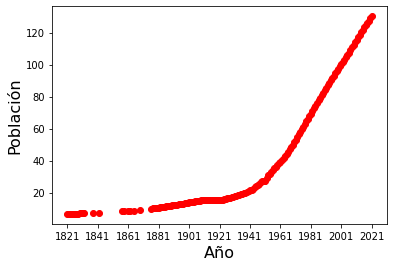

In [98]:

# Gráfica del .csv con matplotlib
plt.xlabel('Año', size = 16)
plt.ylabel('Población', size = 16)
listOf_Xticks = np.arange(1821, 2022, 20)
plt.xticks(listOf_Xticks)
plt.scatter(df['Año'], df['Pob'], color = 'red')
plt.show()


In [689]:

# 3. Separación de los datos 

# Para el conjunto de pruebas, tomando un 32%
test_ratio = 0.32   

# Para el conjunto de entrenamiento, se toma el 68% de la dimensión total de los registros usando .values, len() e int()
train_ratio = int((1.0 - test_ratio) * len(df.values[:,:]))   

# Se usa el método .iloc de pandas para seleccionar los registros por renglon y columna
df_train = df.iloc[0:train_ratio,:]
df_test  = df.iloc[train_ratio:,:]

# Con .shape de pandas se muestran las dimensiones de los conjuntos anteriores
print("Las dimensiones del conjunto de entrenamiento son:", df_train.shape)
print("Las dimensiones del conjunto de pruebas son:", df_test.shape)


Las dimensiones del conjunto de entrenamiento son: (166, 2)
Las dimensiones del conjunto de pruebas son: (79, 2)



<font size = 3>
Usando que:
$$x_{i,norm} = \dfrac{x_{i}-\mu}{\sigma}$$
    
$$y_{i,norm} = \dfrac{y_{i}-\mu}{\sigma}$$
    
    

In [690]:

"""
Usando las expresiones anteriores, con los métodos .mean() y std() de pandas se obtienen el promedio y la desviación
estándar del conjunto de entrenamiento respectivamente
"""
df_train_norm = (df_train - df_train.mean()) / df_train.std()

# Normalizando el conjunto de pruebas con el promedio y desviación del conjunto de entrenamiento
df_test_norm = (df_test - df_train.mean()) / df_train.std()


In [691]:

"""
El método .values extraen por medio de las variables X y Y las columnas del Data frame convierténdose en arreglos numpy y se separan
los valores de entrada y salida
"""

train_x = df_train_norm.values[:,:-1]
train_y = df_train_norm.values[:,-1:]

test_x = df_test_norm.values[:,:-1]
test_y = df_test_norm.values[:,-1:]


In [692]:

# Se transponen con .T los conjuntos para que sean óptimos en la aplicación para la red neuronal
x_train = train_x.T
x_test = test_x.T

y_train = train_y.T
y_test = test_y.T



<center>

Se utilizará una red neuronal tipo FFF:

</center>


In [693]:

import networkx as nx


In [694]:

# 4

class Network(object):
    
    def  __init__ (self,sizes):
        self.num_layers = len(sizes)
        print("It has", self.num_layers, "layers,")
        self.sizes = sizes
        print("with the following number of nodes per layer",self.sizes)
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]
        
    def feedforward(self, x_of_sample):
        """Return the output of the network F(x_of_sample) """        
        for b, w in zip(self.biases, self.weights):
            x_of_sample = sigmoid(np.dot(w, x_of_sample)+b)
        return x_of_sample
    
    def graph(self,sizes):
        a=[]
        ps={}
        Q = nx.Graph()
        for i in range(len(sizes)):
            Qi=nx.Graph()    
            n=sizes[i]
            nodos=np.arange(n)
            Qi.add_nodes_from(nodos)
            l_i=Qi.nodes
            Q = nx.union(Q, Qi, rename = (None, 'Q%i-'%i))
            if len(l_i)==1:
                ps['Q%i-0'%i]=[i/(len(sizes)), 1/2]
            else:
                for j in range(len(l_i)+1):
                    ps['Q%i-%i'%(i,j)]=[i/(len(sizes)),(1/(len(l_i)*len(l_i)))+(j/(len(l_i)))]
            a.insert(i,Qi)
        for i in range(len(a)-1):
            for j in range(len(a[i])):
                for k in range(len(a[i+1])):
                    Q.add_edge('Q%i-%i' %(i,j),'Q%i-%i' %(i+1,k))
        nx.draw(Q, pos = ps)    
        

In [695]:

"""
La siguiente función genera la cantidad de neuronas por capa de la red neuronal FFF, se conviene el número de nodos de la
capa oculta
"""

def layer_sizes(X, Y, n_h):
    
    n_x = X.shape[0] 
    n_h = n_h
    n_y = Y.shape[0]
    
    return (n_x, n_h, n_y)


In [696]:

# Comprobando
n_h = 1
n_x, n_h, n_y = layer_sizes(x_train, y_train, n_h = n_h)

print("No. de neuronas en la capa de entrada:", n_x)
print("No. de neuronas en la capa oculta:", n_h)
print("No. de neuronas en la capa de salida:", n_y)


No. de neuronas en la capa de entrada: 1
No. de neuronas en la capa oculta: 1
No. de neuronas en la capa de salida: 1


It has 3 layers,
with the following number of nodes per layer [1, 1, 1]


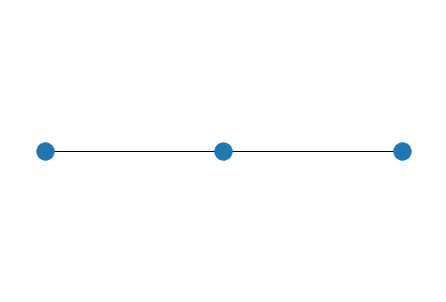

In [697]:

# Utilizando la clase Network se realiza el esquema de la red neuronal con las características pedidas
layers = [n_x, n_h, n_y]
net = Network(layers)
net.graph(layers)


In [698]:

# Personalmente me aseguro de tener bien instalado keras en mi entorno de anaconda navigator
keras.__version__


'2.9.0'

In [727]:

def architecture(input_shape, activation):
    
    """
    Implementación del modelo secuencial (izquierda-derecha) con el método Sequential() de keras.
    Con los métodos de keras .add se añade una capa, Dense() para conectar todos los nodos actuales con los nodos 
    anteriores específicando n_h = 1 número de nodos en el caso de nuestro modelo y usando la notación kernel_initializer
    como los pesos iniciales en una distribución uniforme y los bias en cero
    """

    model = Sequential() 
    
    # Capa de entrada y capa oculta
    model.add(Dense(1, kernel_initializer = 'uniform', bias_initializer = 'zeros', 
                    activation=activation, 
                    input_shape=input_shape))
    
    # Capa de salida
    model.add(Dense(1, kernel_initializer = 'uniform', bias_initializer = 'zeros', 
                    activation = activation))
    
    return model


In [728]:

# Como dimensión de entrada para nuestro problema en partícular se toma el número de rasgos (n_x = 1)
input_shape = (1,)

# Como activador se usa la notación 'softplus' para la función 
model_keras = architecture(input_shape = input_shape, activation = 'softplus')


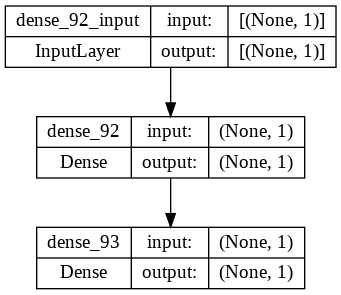

In [729]:

"""
El método plot_model() de keras devuelve una imagen donde se visualizan de manera gráfica todas las capas con sus
respectivos numero de nodos que entran y salen en la red neuronal
"""

plot_model(model_keras, to_file = 'model.png', show_shapes = True, rankdir = 'TB', 
      expand_nested = True, show_layer_names = True, dpi = 96)


In [730]:

# Con el método .summary() se muestra una tabla con la información de todas las capas de la red neuronal
model_keras.summary()


Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_92 (Dense)            (None, 1)                 2         
                                                                 
 dense_93 (Dense)            (None, 1)                 2         
                                                                 
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [731]:

# Valor alpha
lr = 0.95

# Optimizador Adam
opt = Adam(learning_rate = lr)

# Con los métodos losses.MeanSquaredError() "apilados" se define al costo o pérdidas con el error cuadrático medio
loss = tf.keras.losses.MeanSquaredError()

# Análogamente con la presición pero mediante el método .metrics
acc = tf.keras.metrics.MeanSquaredError()

# Con el método .compile se compila la red neuronal usando la métrica basada en los anteriores hiperparámetros
model_keras.compile(loss = loss, 
              optimizer = opt,
              metrics = [acc])


In [732]:

# Número de épocas para el entrenamiento
epochs = 200

"""
Con el método .time() de la paquetería time se genera un reloj interno que devuelve el tiempo de ejecución en que un 
código es ejecutado por la computador
"""
start_time = time.time()

"""
Se indica el porcentaje de muestras en float para el conjunto de validación, en este caso 5% ~ 0.05, por lo que para 
el conjunto de entrenamiento sería el 95% ~ 0.95 
"""
val_split = 0.05

"""
Con el método .fit se entrena al modelo model_keras, con el parámetro batch_size se especifica el número de muestras por
lote y así que el entrenamiento sea más óptimo
"""
history_model = model_keras.fit(train_x, train_y,
                          epochs = epochs,
                          batch_size = 17,
                          validation_split = val_split, 
                          shuffle= True,
                          verbose = 2)

end_time = time.time()

print("Duración del entrenamiento {:10.4f}s".format(end_time - start_time))


Epoch 1/200
10/10 - 1s - loss: 0.8832 - mean_squared_error: 0.8832 - val_loss: 4.8757 - val_mean_squared_error: 4.8757 - 597ms/epoch - 60ms/step
Epoch 2/200
10/10 - 0s - loss: 0.7660 - mean_squared_error: 0.7660 - val_loss: 4.9053 - val_mean_squared_error: 4.9053 - 57ms/epoch - 6ms/step
Epoch 3/200
10/10 - 0s - loss: 0.7676 - mean_squared_error: 0.7676 - val_loss: 4.9095 - val_mean_squared_error: 4.9095 - 60ms/epoch - 6ms/step
Epoch 4/200
10/10 - 0s - loss: 0.7679 - mean_squared_error: 0.7679 - val_loss: 4.9104 - val_mean_squared_error: 4.9104 - 40ms/epoch - 4ms/step
Epoch 5/200
10/10 - 0s - loss: 0.7680 - mean_squared_error: 0.7680 - val_loss: 4.9104 - val_mean_squared_error: 4.9104 - 46ms/epoch - 5ms/step
Epoch 6/200
10/10 - 0s - loss: 0.7680 - mean_squared_error: 0.7680 - val_loss: 4.9101 - val_mean_squared_error: 4.9101 - 39ms/epoch - 4ms/step
Epoch 7/200
10/10 - 0s - loss: 0.7679 - mean_squared_error: 0.7679 - val_loss: 4.9095 - val_mean_squared_error: 4.9095 - 44ms/epoch - 4ms/st

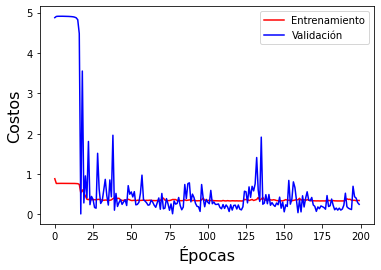

In [733]:

plt.plot(history_model.history['loss'], 'red')
plt.plot(history_model.history['val_loss'], 'blue')
plt.ylabel('Costos', size=16)
plt.xlabel('Épocas', size=16)
plt.legend(['Entrenamiento', 'Validación'], loc='upper right');


In [739]:

scores = model_keras.evaluate(test_x, test_y)
print('Test loss:', scores[0])


3/3 [==============================] - 0s 5ms/step - loss: 0.3511 - mean_squared_error: 0.2611
Test loss: 0.3510544300079346


In [735]:

# 5
predictions = model_keras.predict(test_x)
print(len(predictions))


3/3 [==============================] - 0s 3ms/step
79


In [742]:

# Se revierte la nomralización y se realizan algunas predicciones:
(predictions[0] * df_train.std()) + df_train.mean()   # Año 2022


Año    2022.982730
Pob     133.477284
dtype: float64


In [747]:

# Año 2050
(predictions[28] * df_train.std()) + df_train.mean()


Año    2055.000109
Pob     152.927630
dtype: float64


In [746]:

# Año 2100
(predictions[78] * df_train.std()) + df_train.mean()


Año    2113.820014
Pob     147.196035
dtype: float64


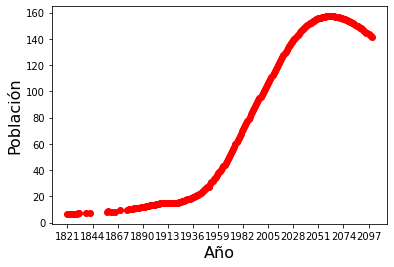

In [755]:

# Comparando con las proyecciones hechas por el Banco Mundial:

plt.xlabel('Año', size = 16)
plt.ylabel('Población', size = 16)
listOf_Xticks = np.arange(1821, 2100, 23)
plt.xticks(listOf_Xticks)
plt.scatter(df['Año'], df['Pob'], color = 'red')
plt.show()
# plt.scatter(df['Año'], model_keras.predict(df['Año']))

In [762]:
print(df.values[166])

[2022.        131.753424]


In [763]:
print(df.values[194])

[2050.        155.166262]


In [764]:
print(df.values[244])

[2100.        141.509942]
